In [1]:
!pip install pareto

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pareto
import math

In [3]:
dataset = 'anime' # 'ml100k', 'ml1m', 'ft', 'anime'

## Frente de pareto

Load GridSearch results:

In [4]:
df = {}
for m in ['ResBeMF', 'BeMF', 'DirMF', 'PMF', 'MLP']:
    aux = pd.read_csv('results/gridsearch/' + dataset + '/' + m.lower() +'.csv')
    aux = aux[aux['cummulativemae_avg'] >= 0.05]
    aux = aux[aux['cummulativecoverage_avg'] >= 0.05]
    df[m] = aux

Plot the scatter:

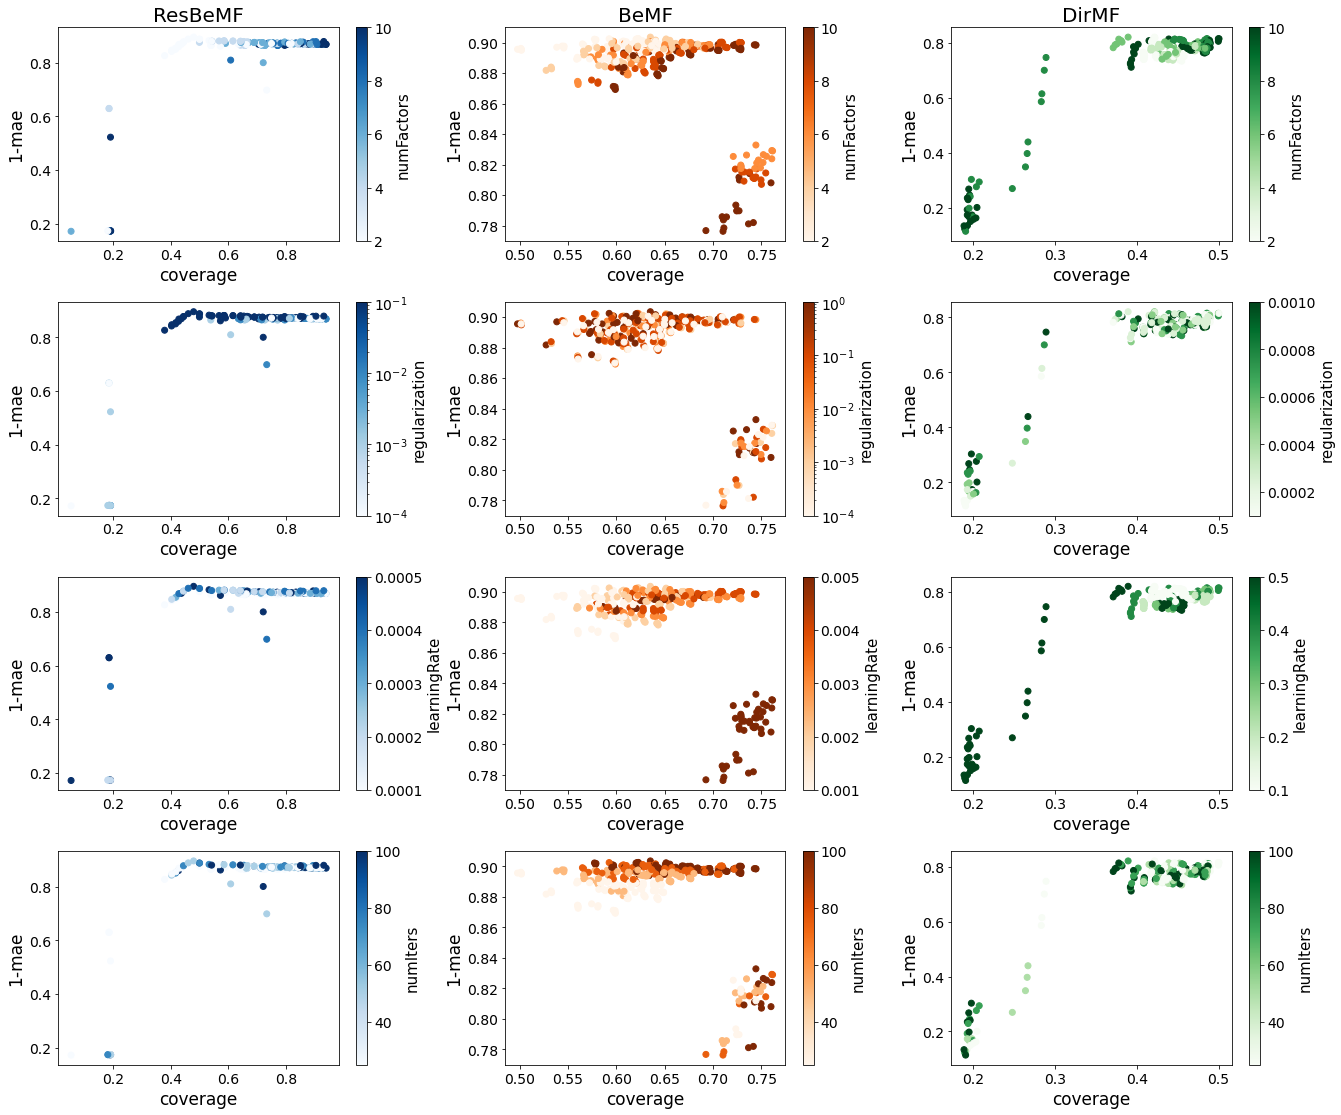

In [5]:
params = ['numFactors', 'regularization', 'learningRate', 'numIters']
methods = ['ResBeMF', 'BeMF', 'DirMF']
cmaps = ['Blues', 'Oranges', 'Greens']

fig, axs = plt.subplots(len(params), len(methods), figsize=(6*len(methods),3.75*len(params)))
fig.tight_layout(h_pad=4, w_pad=6.5)

for i, param in enumerate(params):
    for j, method in enumerate(methods):
        
        axs[i,j].set_xlabel('coverage', fontsize=17)
        axs[i,j].set_ylabel('1-mae', fontsize=17)
        
        if i == 0:
            axs[i,j].set_title(method, fontsize=20)
            
        axs[i,j].tick_params(axis='both', which='major', labelsize=14)
            
        mae = df[method]['cummulativemae_avg']
        coverage = df[method]['cummulativecoverage_avg']
        color = df[method][param] 
                    
        norm = colors.LogNorm(vmin=color.min(), vmax=color.max()) if param == 'regularization' and (method == 'BeMF' or (method == 'ResBeMF' and dataset == 'anime')) else None
        
        im = axs[i,j].scatter(coverage, mae, c=color, cmap=cmaps[j], norm=norm)
        
        cbar = plt.colorbar(im, ax=axs[i,j])
        cbar.set_label(param, fontsize=15)
        cbar.ax.tick_params(labelsize=14)
        
plt.savefig('./figs/' + dataset + '-hyperparameters.png', dpi=300, bbox_inches='tight')

Plot the pareto fronts:

In [6]:
def get_pareto_front(df):
    objectives = [df.columns.get_loc(c) for c in ['cummulativemae_avg', 'cummulativecoverage_avg'] if c in df]
    nondominated = pareto.eps_sort([list(df.itertuples(False))], objectives, maximize_all=True)
    pareto_front = pd.DataFrame.from_records(nondominated, columns=list(df.columns.values))
    s = sorted(zip(pareto_front['cummulativecoverage_avg'], pareto_front['cummulativemae_avg']))
    cov, mae = [list(tuple) for tuple in zip(*s)]
    return cov, mae

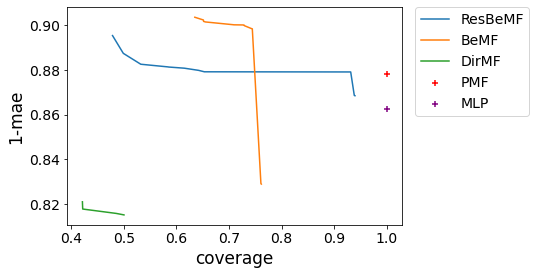

In [7]:
resbemf_coverage, resbemf_mae = get_pareto_front(df['ResBeMF'])
plt.plot(resbemf_coverage, resbemf_mae, label='ResBeMF')

bemf_coverage, bemf_mae = get_pareto_front(df['BeMF'])
plt.plot(bemf_coverage, bemf_mae, label='BeMF')

dirmf_coverage, dirmf_mae = get_pareto_front(df['DirMF'])
plt.plot(dirmf_coverage, dirmf_mae, label='DirMF')

pmf_coverage, pmf_mae = get_pareto_front(df['PMF'])
plt.scatter(pmf_coverage, pmf_mae, label='PMF', c='red', marker='+')

mlp_coverage, mlp_mae = get_pareto_front(df['MLP'])
plt.scatter(mlp_coverage, mlp_mae, label='MLP', c='purple', marker='+')

plt.xlabel('coverage', fontsize=17)
plt.xticks(fontsize=14)

plt.ylabel('1-mae', fontsize=17)
plt.yticks(fontsize=14)
    
plt.legend(fontsize=14, loc=(1.04, 0.5))

plt.savefig('./figs/' + dataset + '-pareto-front.png', dpi=300, bbox_inches='tight')

## Test split error

Load test split results:

In [8]:
mae_df = pd.read_csv('results/test-split/' + dataset + '/mae.csv')
mae_df

,reliability,ResBeMF_0,ResBeMF_1,ResBeMF_2,ResBeMF_3,ResBeMF_4,ResBeMF_5,ResBeMF_6,ResBeMF_7,ResBeMF_8,...,BeMF_11,BeMF_12,DirMF_0,DirMF_1,DirMF_2,DirMF_3,DirMF_4,DirMF_5,PMF,MLP
0,0.00,0.865012,0.867929,0.867299,0.866101,NaN,NaN,NaN,0.867863,0.868168,...,0.749977,0.812460,0.841083,0.827388,0.873741,0.873826,0.827311,0.873826,0.876124,0.862935
1,0.05,0.865012,0.867929,0.867299,0.866101,NaN,NaN,NaN,0.867863,0.868168,...,0.749977,0.812460,0.841083,0.827388,0.873741,0.873826,0.827311,0.873826,0.876124,0.862935
2,0.15,0.866239,0.869333,0.867572,0.866834,NaN,NaN,NaN,0.869807,0.868943,...,0.749971,0.812459,0.848302,0.828822,0.884889,0.884943,0.828614,0.884926,0.876124,0.862935
3,0.20,0.870680,0.871839,0.869421,0.869991,NaN,NaN,NaN,0.872981,0.870576,...,0.758699,0.812446,0.853998,0.829423,0.900952,0.901417,0.828915,0.901043,0.876124,0.862935
4,0.25,0.873456,0.875999,0.870820,0.872117,NaN,NaN,NaN,0.878604,0.872706,...,0.777406,0.814432,0.861390,0.830415,0.915921,0.916426,0.829934,0.916123,0.876124,0.862935
5,0.30,0.876468,0.882197,0.872268,0.874595,NaN,NaN,NaN,0.886505,0.876817,...,0.777789,0.816168,0.866995,0.831302,0.929452,0.929272,0.831401,0.929644,0.876124,0.862935
6,0.35,0.880348,0.889765,0.873869,0.877534,NaN,NaN,NaN,0.895030,0.882787,...,0.803383,0.823319,0.872018,0.833125,0.941157,0.940904,0.832094,0.941139,0.876124,0.862935
7,0.40,0.884488,0.899494,0.876916,0.881373,NaN,NaN,NaN,0.906119,0.888054,...,0.803974,0.823415,0.875408,0.833989,0.955703,0.955877,0.833812,0.956064,0.876124,0.862935
8,0.45,0.889027,0.910379,0.880300,0.885317,NaN,NaN,NaN,0.914175,0.892546,...,0.804360,0.824984,0.876875,0.829703,0.969298,0.969069,0.829770,0.969241,0.876124,0.862935
9,0.50,0.891259,0.919422,0.882849,0.889380,NaN,NaN,NaN,0.925370,0.887183,...,0.800836,0.834471,0.882757,0.819650,0.982004,0.981802,0.821223,0.981888,0.876124,0.862935


In [9]:
coverage_df = pd.read_csv('results/test-split/' + dataset + '/coverage.csv')
coverage_df

,reliability,ResBeMF_0,ResBeMF_1,ResBeMF_2,ResBeMF_3,ResBeMF_4,ResBeMF_5,ResBeMF_6,ResBeMF_7,ResBeMF_8,...,BeMF_11,BeMF_12,DirMF_0,DirMF_1,DirMF_2,DirMF_3,DirMF_4,DirMF_5,PMF,MLP
0,0.00,1.000000e+00,1.000000,1.000000,1.000000,0,0,0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1
1,0.05,1.000000e+00,1.000000,1.000000,1.000000,0,0,0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1
2,0.15,9.899196e-01,0.988839,0.997952,0.994352,0,0,0,0.983734,0.994216,...,0.999912,0.999959,0.976172,0.979823,0.693337,0.691963,0.980169,0.692976,1,1
3,0.20,9.386424e-01,0.946905,0.984587,0.965337,0,0,0,0.910235,0.976469,...,0.906130,0.999375,0.908654,0.958898,0.271007,0.270151,0.957440,0.270905,1,1
4,0.25,8.655071e-01,0.783913,0.968755,0.926557,0,0,0,0.668966,0.908545,...,0.677017,0.968937,0.723010,0.760260,0.144399,0.144346,0.757883,0.144505,1,1
5,0.30,7.188683e-01,0.484599,0.926297,0.836242,0,0,0,0.361295,0.661901,...,0.665263,0.888268,0.456030,0.432613,0.095176,0.095276,0.437828,0.095264,1,1
6,0.35,5.046071e-01,0.226487,0.826956,0.671182,0,0,0,0.159222,0.337983,...,0.347519,0.799761,0.237296,0.199067,0.065016,0.065191,0.209568,0.065021,1,1
7,0.40,2.957948e-01,0.093194,0.625336,0.438293,0,0,0,0.065419,0.141507,...,0.344413,0.720936,0.107771,0.083455,0.041736,0.042125,0.092314,0.041973,1,1
8,0.45,1.581564e-01,0.035669,0.398061,0.249216,0,0,0,0.025451,0.056487,...,0.332327,0.561060,0.043781,0.031915,0.023758,0.024070,0.038747,0.023784,1,1
9,0.50,8.168013e-02,0.012678,0.227610,0.132959,0,0,0,0.009196,0.019832,...,0.108776,0.449205,0.015321,0.010686,0.006758,0.006792,0.014695,0.006772,1,1


Remove mae values computed with a coverage less than 0.01:

In [10]:
for c in mae_df.columns.tolist()[1:]:
    for i in range(mae_df['reliability'].size):
        if coverage_df[c][i] <= 0.01:
            mae_df[c][i] = math.nan

Compute aveage error and its std:

In [11]:
for method in ["ResBeMF", "BeMF", "DirMF"]:
    mae_df[method + "_mean"] = mae_df.loc[:, mae_df.columns.str.startswith(method)].mean(axis=1)
    mae_df[method + "_std"] = mae_df.loc[:, mae_df.columns.str.startswith(method)].std(axis=1)

In [12]:
for method in ["ResBeMF", "BeMF", "DirMF"]:
    coverage_df[method + "_mean"] = coverage_df.loc[:, coverage_df.columns.str.startswith(method)].mean(axis=1)
    coverage_df[method + "_std"] = coverage_df.loc[:, coverage_df.columns.str.startswith(method)].std(axis=1)

Plot the figure:

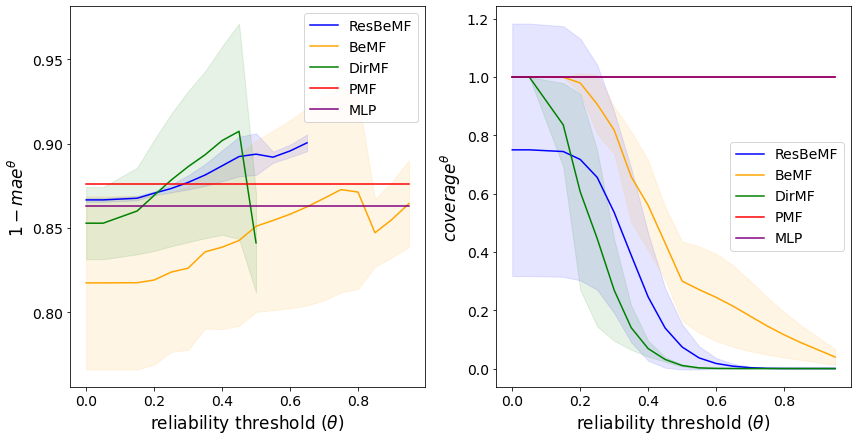

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14,7))

def plot_axis(df, name, ax):
    ax.set_xlabel(r'reliability threshold ($\theta$)', fontsize=17)
    ax.set_ylabel(name, fontsize=17)

    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.fill_between(df['reliability'], df['ResBeMF_mean'] + df['ResBeMF_std'], df['ResBeMF_mean'] - df['ResBeMF_std'], color='blue', alpha=0.1)
    ax.plot(df['reliability'], df['ResBeMF_mean'], c='blue', label='ResBeMF')

    ax.fill_between(df['reliability'], df['BeMF_mean'] + df['BeMF_std'], df['BeMF_mean'] - df['BeMF_std'], color='orange', alpha=0.1)
    ax.plot(df['reliability'], df['BeMF_mean'], c='orange', label='BeMF')

    ax.fill_between(df['reliability'], df['DirMF_mean'] + df['DirMF_std'], df['DirMF_mean'] - df['DirMF_std'], color='green', alpha=0.1)
    ax.plot(df['reliability'], df['DirMF_mean'], c='green', label='DirMF')
    
    ax.plot(df['reliability'], df['PMF'], c='red', label='PMF')

    ax.plot(df['reliability'], df['MLP'], c='purple', label='MLP')

    ax.legend(fontsize=14)
    
plot_axis(mae_df, '$1-mae^θ$', axs[0])
plot_axis(coverage_df, '$coverage^θ$', axs[1])

plt.savefig('./figs/' + dataset + '-test-error.png', dpi=300, bbox_inches='tight')